In [144]:
import sympy as sp
import numpy as np
from IPython.display import display, Math
import time
import matplotlib.pyplot as plt

### Función Objetivo (Six-Hump Camel Function)

In [145]:
def funcion_obj(x, y):
    return ((4 - (2.1 * x**2) + (x**4 / 3)) * x**2) + (x * y) + ((-4 + (4 * y**2)) * y**2)

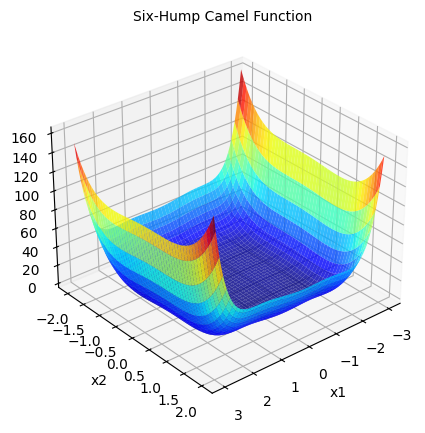

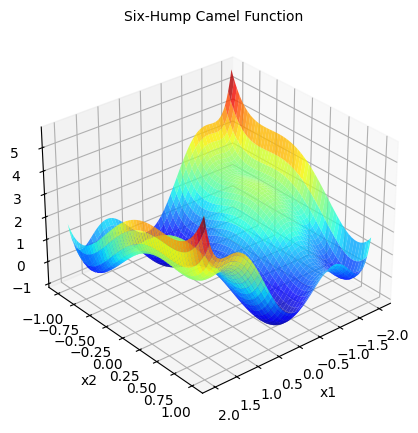

In [146]:
def grafica_1():
    x1 = np.linspace(-3, 3, 100)
    x2 = np.linspace(-2, 2, 100)
    X1, X2 = np.meshgrid(x1, x2)
    Z = funcion_obj(X1, X2)

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X1, X2, Z, cmap='jet', alpha=0.8)
        
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Six-Hump Camel Function', fontsize=10)

    ax.view_init(elev=30, azim=50)  

    plt.show()

def grafica_2():
    x1 = np.linspace(-2, 2, 100)
    x2 = np.linspace(-1, 1, 100)
    X1, X2 = np.meshgrid(x1, x2)
    Z = funcion_obj(X1, X2)

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X1, X2, Z, cmap='jet', alpha=0.8)
        
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Six-Hump Camel Function', fontsize=10)

    ax.view_init(elev=30, azim=50)  

    plt.show()

grafica_1()
grafica_2()

### Gradiente de la función ( ∇f(x,y) )

In [147]:
x, y = sp.symbols('x y')
grad = [sp.diff(funcion_obj(x, y), x),sp.diff(funcion_obj(x, y), y)]
display(Math(sp.latex(grad)))

<IPython.core.display.Math object>

In [148]:
def gradiente(xk):
    x, y = sp.symbols('x y')
    grad_x = sp.diff(funcion_obj(x, y), x).subs([(x, xk[0]), (y, xk[1])])
    grad_y = sp.diff(funcion_obj(x, y), y).subs([(x, xk[0]), (y, xk[1])])
    grad = np.array([grad_x, grad_y], dtype=float)
    return grad

### Hessiana

In [149]:
x, y = sp.symbols('x y')
hess = sp.hessian(funcion_obj(x, y), (x, y))
display(Math(sp.latex(hess)))

<IPython.core.display.Math object>

In [150]:
def hessiana(xk):
    x, y = sp.symbols('x y')
    hess = sp.hessian(funcion_obj(x, y), (x, y))
    hess_num = np.array(hess.subs({x: xk[0], y: xk[1]})).astype(np.float64)
    return hess_num

### Busqueda Lineal (α* = min Φ(α))

In [151]:
def busqueda_lineal(xk, pk):
    a = sp.symbols('a')
    x, y = sp.symbols('x y')
    xk_apk = xk + a * pk
    f = funcion_obj(x, y)
    func_val = f.subs([(x, xk_apk[0]), (y, xk_apk[1])])
    min_phialpha = sp.diff(func_val, a)
    a_values = sp.solve(min_phialpha, a)
    
    if a_values:
        func_min_value = float('inf')
        opt_a = None
        for a_val in a_values:
            if a_val.is_real:
                func_val_at_a = func_val.subs(a, a_val)
                if func_val_at_a < func_min_value:
                    func_min_value = func_val_at_a
                    opt_a = a_val
        if opt_a is not None:
            return float(opt_a)
    
    return 1.0

### Método Gradiente Descendente

In [152]:
def grad_descendente(tolerancia, n_iter, x0):
    print("MÉTODO DE GRADIENTE DESCENDENTE")
    xk = x0
    print("Iteración\tAlpha\t\t\tXk")
    for k in range(n_iter):
        g = gradiente(xk)
        pk = -g
        norma_pk = np.linalg.norm(pk)
        if norma_pk <= tolerancia:
            return xk
        else:
            alpha = busqueda_lineal(xk, pk)
            xk = xk + alpha * pk
            print(f"{k+1}\t\t{alpha}\t{xk}")
    return xk

### Método Newton

In [153]:
def newton(tolerancia, n_iter, x0):
    print("MÉTODO DE NEWTON")
    xk = x0
    print("Iteración\tAlpha\t\t\tXk")
    for k in range(n_iter):
        hess_inv = np.linalg.inv(hessiana(xk))
        pk = -np.dot(hess_inv, gradiente(xk))
        norma_pk = np.linalg.norm(pk)
        if norma_pk <= tolerancia:
            return xk
        else:
            alpha = busqueda_lineal(xk, pk)
            xk = xk + alpha * pk
            print(f"{k+1}\t\t{alpha}\t{xk}")
    return xk

### Método Cuasi_Newton (Se utiliza una formula a la de las diapositivas para Cuasi-Update) 
##### $$ B_{k+1} = (I - \rho_k s_k y_k^T) B_k (I - \rho_k y_k s_k^T) + \rho_k s_k s_k^T $$


In [154]:
def cuasi_newton(tol, n_iter, x0):
    print("MÉTODO DE CUASI-NEWTON")
    xk = x0
    print("Iteración\tAlpha\t\t\tXk")
    B = np.eye(2)
    for k in range(n_iter):
        gk = gradiente(xk)
        pk = -np.dot(B, gk)
        norma_pk = np.linalg.norm(pk)
        if norma_pk <= tol:
            return xk
        else:
            alpha = busqueda_lineal(xk, pk)
            xk1 = xk + alpha * pk
            sk = xk1 - xk
            yk = gradiente(xk1) - gradiente(xk)
            if np.dot(yk, sk) > 0:  
                rho_k = 1.0 / np.dot(yk, sk)
                I = np.eye(len(xk))
                t1 = (I - rho_k * np.outer(sk, yk)) @ B @ (I - rho_k * np.outer(yk, sk))
                t2 = rho_k * np.outer(sk, sk)
                B = t1 + t2
            xk = xk1
            print(f"{k+1}\t\t{alpha}\t{xk}")
    return xk

### Método Direcciones Conjugadass / Powell

In [155]:
def powell(tolerancia, n_iter, x0):
    print("MÉTODO DE POWELL")
    xk = x0
    print("Iteración\tAlpha\t\t\tXk")
    n = len(xk)
    directions = np.eye(n)
    k = 0

    while k < n_iter:
        Z = np.array(xk, dtype=float)
        for i in range(n):
            si = directions[i]
            if funcion_obj(*(xk + 0.01 * si)) < funcion_obj(*xk):
                si = si
            else:
                si = -si
            alpha = busqueda_lineal(xk, si)
            xk += alpha * si
        sn = xk - Z
        alpha = busqueda_lineal(xk, sn)
        xk += alpha * sn
        if np.linalg.norm(xk - (Z + alpha * sn)) < tolerancia:
            return xk
        directions[:-1] = directions[1:]
        directions[-1] = sn / np.linalg.norm(sn)
        k += 1
        print(f"{k+1}\t\t{alpha}\t{xk}")

    return xk

### Menú

In [156]:
opciones = {
    '1': grad_descendente,
    '2': newton,
    '3': cuasi_newton,
    '4': powell,
}

x , y= sp.symbols('x  y')
expr = funcion_obj(x,y)
print("Función objetivo:")
display(Math(sp.latex(expr)))

print("Seleccione un método de optimización:")
print("1. Método Gradiente Descendente")
print("2. Método Newton")
print("3. Método Cuasi-Newton")
print("4. Método Powell")
print("0. Salir")

opcion = input("Ingrese el número correspondiente al método deseado: ")

if opcion in opciones:
    n_iter = int(input("Introduce el número máximo de iteraciones: "))
    tol = float(input("Introduce la tolerancia: "))
    valores = [float(input(f"Introduce el valor {i+1} de x0: ")) for i in range(2)]
    x0 = np.array(valores, dtype=float)
    start_time = time.time()
    optimo = opciones[opcion](tol, n_iter, x0)
    end_time = time.time()
    print(f"Mínimo global x* = {optimo.round(5)} con valor de f(x*) = {funcion_obj(optimo[0],optimo[1]).round(5)}")
    execution_time = end_time - start_time
    print(f"Tiempo de ejecución: {execution_time} segundos")
elif opcion == "0":
    print("Programa terminado")
else:
    print("Opción inválida.")

Función objetivo:


<IPython.core.display.Math object>

Seleccione un método de optimización:
1. Método Gradiente Descendente
2. Método Newton
3. Método Cuasi-Newton
4. Método Powell
0. Salir
MÉTODO DE POWELL
Iteración	Alpha			Xk
2		1.3398359893475948	[-0.1768398   0.66016401]
3		-0.8909064504407619	[-0.07363125  0.68371828]
4		0.1279380204097341	[-0.08975414  0.71267496]
5		0.0004506315035647498	[-0.08984201  0.7126564 ]
Mínimo global x* = [-0.08984  0.71266] con valor de f(x*) = -1.03163
Tiempo de ejecución: 42.39442420005798 segundos
